<a href="https://colab.research.google.com/github/edogriba/NAML-2024/blob/main/LAB05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 05

## Kernel SVM

Support Vector Machine with OSQP

In this exercise, we will implement a Support Vector Machine (SVM) using the OSQP (Operator Splitting Quadratic Program) solver. We will focus on the Radial Basis Function (RBF) kernel and visualize the decision boundary and support vectors.

Objectives
- Implement SVM with an RBF kernel using OSQP.
- Solve the SVM optimization problem.
- Compute the decision boundary and support vectors.
- Visualize the results.

### Step 1: Import Libraries

We will begin by importing the necessary libraries. JAX will be used for numerical computations, OSQP for optimization, and Matplotlib for visualization.

In [77]:
!pip install jaxopt

import jax
import jax.numpy as jnp
from jaxopt import BoxOSQP

import numpy as np
from sklearn import datasets
from sklearn import preprocessing
import matplotlib.pyplot as plt

### Step 2: Define the RBF Kernel

The Radial Basis Function (RBF) kernel is defined as follows:
$$ K(x, y) = \exp(-\gamma \|x - y\|^2) $$

Where $ \gamma $ is a parameter that determines the spread of the kernel. We will implement this kernel as a function.

In [78]:
def rbf_kernel(X1, X2, gamma): # each entry must be the distance of these two points
    # This must work when X1 and X2 are matrices
    # each element of the kernel, given two vectors x1, x2 as inputs is
    # exp(- \gamma (||x_1||^2 + ||x_2||^2 - 2 <x_1, x_2>))
    # Compute ||x_1||^2, ||x_2||^2, <x_1, x_2> separatly with X1, X2 matrices
    # and than combine them together (use broadcasting)
  sq_dist = -2 * jnp.dot(X1, X2.T) + jnp.sum(X1**2, axis=1)[:, None] + jnp.sum(X2**2, axis=1)[None, :]
    # if X1 has shape (n1, dim) and X2 has shape (n2, dim)
    # the output shall have shape (n1, n2)
  return jnp.exp(-gamma * sq_dist)

### Step 3: Define the SVM Optimization with OSQP

The objective of the Support Vector Machine (SVM) is to find a hyperplane that separates data points of different classes with the maximum margin. The formulation of the SVM optimization problem can be derived as follows:

#### Dual Problem

The dual form of the SVM optimization problem is derived from the primal problem using dual coefficients (see Representer Theorem). The dual problem is given by:

$$
\begin{aligned}
& \text{minimize} && \frac{1}{2} \beta^T K \beta - \beta^T \mathbf{y}  \\
& \text{subject to} && \sum_{i=1}^{n} \beta_i = 0 \\
& && -C \leq \beta_i \leq 0, \quad \forall i \text{ if } y_i =-1\\
& && 0 \leq \beta_i \leq C, \quad \forall i \text{ if } y_i =1
\end{aligned}
$$

Where:
- $ \beta_i $ are the dual coefficients.
- $ K(X_i, X_j) $ is the kernel function, which in our case is the Radial Basis Function (RBF) kernel defined as:
  
$$
K(X_i, X_j) = \exp(-\gamma \|X_i - X_j\|^2)
$$

#### OSQP Formulation

In the context of OSQP, we reformulate the dual problem in terms of matrix-vector products for efficient computation. The dual optimization problem is rewritten as:

1. **Quadratic Objective**:

   $$
   \text{minimize} \quad \frac{1}{2} \mathbf{\beta}^T K \mathbf{\beta} - \mathbf{y}^T \mathbf{\beta}
   $$


2. **Linear Constraints**:

   $$
   A \mathbf{\beta} = \mathbf{z}
   $$
   
   $$
   l \leq \mathbf{z} \leq u
   $$

   Where:
   - $ A $ is the constraint matrix.
   - $ l $ and $ u $ are the lower and upper bounds for $ \beta_i $, derived from the constraints of the dual problem.

By using the OSQP solver, we can efficiently solve this quadratic program to obtain the optimal values of $ \beta $, which can then be used to compute the weight vector $ \beta $ and the bias $ b $ for classification.

In our case we have that
- $A$: is the identity
- We implement the equality constraint on the sum of $\beta$ as $0 \leq \sum_{i=0}^n \beta_i \leq 0$


In [79]:
def binary_kernel_svm_osqp(X, y, C, gamma):
    K = rbf_kernel(X, X, gamma)

    # 0.5 beta^T K beta
    def matvec_Q(Q, beta):
        return jnp.dot(Q, beta)

    # return beta and the sum of betas, for the constrait
    def matvec_A(_, beta):
        return beta, jnp.sum(beta)

    # first element of the tuple is the elementwise constraint on \beta_i
    # second element of the tuple is the constraint on the sum of betas
    # the tuple has size two like the size of the tuple returned by `matvec_A`
    l = -jax.nn.relu(-y * C), 0.
    u = jax.nn.relu(y * C), 0.

    # build and run the optimizer
    osqp = BoxOSQP(matvec_Q=matvec_Q, matvec_A=matvec_A, tol=1e-6)
    params, _ = osqp.run(
        init_params=None,
        params_obj=(K, -y), # parameters passed to `matvec_Q` and used for `y^T \beta`
        params_eq=None,
        params_ineq=(l, u)
    )
    beta = params.primal[0]

    return beta

### Step 4: Compute the Bias Term

The bias term $b$ is computed using one of the support vectors. The formula used is:

$$ b = y_i - \sum_{j} \beta_j K(x_j, x_i) $$

Where $i$ is the index of a support vector.

In [80]:
def compute_bias(X, y, beta, gamma):
    # Compute the bias term b by using a support vector
    support_indices = jnp.where(jnp.abs(beta) > 1e-4)[0]
    if len(support_indices) > 0:
        i = support_indices[0]
        # https://stats.stackexchange.com/questions/451868/calculating-the-value-of-b-in-an-svm
        # the loop on SV is equivalent to a loop on all betas since beta is almost 0
        return y[i]-jnp.sum(beta[support_indices] * rbf_kernel(X[support_indices], X[i:i+1], gamma).reshape((-1,)))
    else:
        return 0.

### Step 5: Decision Function

The decision function computes the predicted output for a test point as follows:
$$ \hat{y}_i = \sum_{i} \beta_i y_i K(x_i, x) + b $$

Where $ x_i $ are the support vectors.

In [81]:
def decision_function(X_train, y_train, X_test, beta, gamma, b):
    K_test = rbf_kernel(X_test, X_train, gamma=gamma)
    b = compute_bias(X_train, y_train, beta, gamma=gamma)
    return K_test @ beta + b

### Step 6: Prepare the Dataset

We will generate a circular dataset using the `make_circles` function from Scikit-learn, scale the data, and transform the labels to \{-1, 1\}.

[[ 0.73984947  0.73694229]
 [ 0.43497316 -0.36007809]
 [ 0.69937529 -0.66178683]
 [-0.42027197 -0.8545037 ]
 [-0.05550975 -0.54570996]
 [-0.37494636 -0.3330314 ]
 [ 0.13229686 -0.49278757]
 [-0.14861849 -1.01665456]
 [ 0.30751949  0.30541104]
 [-0.49471375  0.14932314]
 [-0.4592365   0.8774803 ]
 [ 0.40546379  0.22724459]
 [-0.91351269 -0.2444846 ]
 [ 0.83327534 -0.35726283]
 [-0.48353307 -0.12300242]
 [-0.24425204  0.45027833]
 [ 0.82679752  0.4896542 ]
 [ 0.57176131 -0.22692508]
 [-0.74588122  0.52925948]
 [-0.051239    0.95952503]
 [ 0.16171245  0.49545536]
 [-0.05092077  0.5500528 ]
 [-0.81267617 -0.62107129]
 [-0.98035322  0.18974834]
 [-0.25061724 -0.43090663]
 [ 0.40698179  0.94113523]
 [ 1.01652672 -0.07179142]
 [-0.40313208  0.34992286]
 [ 0.48879806 -0.02100917]
 [ 0.35900848 -0.92950481]]
----------
[0 1 0 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0]


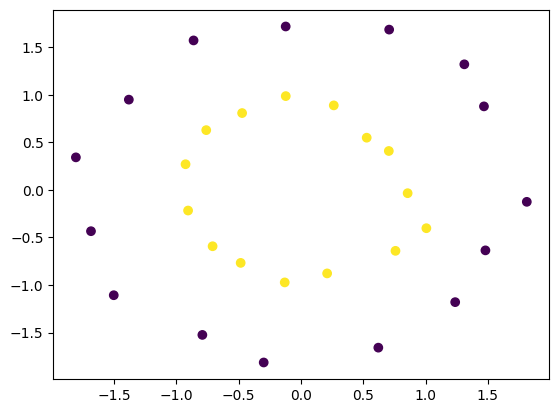

In [82]:
num_samples = 30
lam = 0.001
gamma = 0.5  # Gamma parameter for RBF kernel

np.random.seed(0)

# Prepare circular dataset
X, y = datasets.make_circles(n_samples=num_samples, factor=0.5, noise=0.05)  # Circle data
print(X)
print("----------")
print(y)
X = preprocessing.StandardScaler().fit_transform(X)  # Scale data
y = jnp.array(y * 2. - 1.)  # Transform labels from {0, 1} to {-1., 1.}

C = 1 / (2 * lam * num_samples)

# Plot the data points
plt.scatter(X[:, 0], X[:, 1], c=y)

### Step 7: Train the SVM Model

Now we will solve the SVM optimization problem using OSQP and display the results.

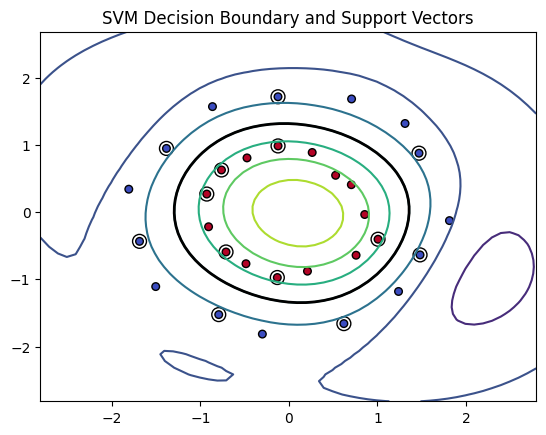

In [83]:
# Solve with OSQP

beta = binary_kernel_svm_osqp(X, y, C, gamma)

# Create a grid of points to evaluate the decision function
h = .1  # Step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Compute the decision function for each point in the grid
# 1. use `jnp.c_`, which concatenate slices, scalars and array-like objects along the last axis
#    to build X_test from `xx` and `yy`
# 2. use `decision_function` to compute the predictions `Z`
X_test = jnp.c_[xx.ravel(), yy.ravel()]
b = compute_bias(X, y, beta, gamma)
Z = decision_function(X, y, X_test, beta, gamma, b)
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, )
# Plot the data points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=30, edgecolors='k')

# Plot the decision boundary and margins
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')  # Decision boundary

support_vectors = jnp.where(jnp.abs(beta) > 1e-4)[0]
# Highlight the support vectors
plt.scatter(X[support_vectors, 0], X[support_vectors, 1], s=100, facecolors='none', edgecolors='k')

plt.title("SVM Decision Boundary and Support Vectors")
plt.show()

In [84]:
from sklearn import svm

K = rbf_kernel(X, X, gamma)  # Compute RBF kernel matrix
svc = svm.SVC(kernel="precomputed", C=C, tol=1e-6).fit(K, y)
beta_sk = np.zeros(K.shape[0])
beta_sk[svc.support_] = svc.dual_coef_[0]
Z_sk = svc.decision_function(rbf_kernel(X_test, X, gamma=gamma))

print(f"Beta discrepancy       {np.max(np.abs(beta_sk - beta)):.3e}")
print(f"Intercept discrepancy  {np.max(np.abs(svc.intercept_ - b)):.3e}")
print(f"Prediction discrepancy {np.max(np.abs(Z_sk - Z.flatten())):.3e}")


Beta discrepancy       4.005e-05
Intercept discrepancy  4.292e-06
Prediction discrepancy 6.199e-06


## Gradient Descent


In this section of the laboratory session, we will explore optimization techniques implemented with **JAX**.
We will cover several optimization algorithms:

- Gradient Descent (GD)
- Gradient Descent with Backtracking Line Search
- Exact Line Search for Quadratic Functions

We will apply these methods on various benchmark functions:

- Rastrigin Function
- Ackley Function
- Quadratic Function

Let's begin by importing the rebuired packages.

In [85]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Set random seed for reproducibility
key = jax.random.PRNGKey(0)

### Helper Functions for Plotting

We define a helper function `plot_optimization_2d` to visualize optimization trajectories on a 2D contour plot. This function will:

- Plot the optimization path taken by Gradient Descent (GD)
- Plot the optimization path with Backtracking Line Search if available
- Show the function's value as a contour plot in the background.


In [86]:
def plot_optimization_2d(func, gd_path, gd_backtrack_path, title):
    x_vals = jnp.linspace(-5, 5, 50)
    y_vals = jnp.linspace(-5, 5, 50)
    X, Y = jnp.meshgrid(x_vals, y_vals)
    Z = jnp.array([[func(jnp.array([x, y])) for x in x_vals] for y in y_vals])

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    cs = axs[0].contourf(X, Y, Z, levels=50, cmap="viridis")
    plt.colorbar(cs)
    axs[0].contour(X, Y, Z, colors="white")

    gd_path = jnp.array(gd_path)

    axs[0].plot(gd_path[:, 0], gd_path[:, 1], "r.-", label="GD")

    if gd_backtrack_path != []:
        gd_backtrack_path = jnp.array(gd_backtrack_path)
        axs[0].plot(
            gd_backtrack_path[:, 0],
            gd_backtrack_path[:, 1],
            ".-",
            color="orange",
            label="GD + backtracking",
        )
    axs[0].set_title(title)
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")
    axs[0].set_ylim([-5, 5])
    axs[0].set_xlim([-5, 5])
    axs[0].legend()

    axs[1].semilogy([func(x) for x in gd_path], "ro-", label="GD")
    axs[1].semilogy(
        [func(x) for x in gd_backtrack_path],
        "o-",
        color="orange",
        label="GD + backtracking",
    )
    axs[1].legend()
    plt.tight_layout()

### Defining Benchmark Functions

### 1. Rastrigin Function

The Rastrigin function is a **non-convex** and **multi-modal** function often used as a test for optimization algorithms.
It is defined as:

$$
f(x) = 10 n + \sum_{i=1}^n \left( x_i^2 - 10 \cos(2 \pi x_i) \right)
$$

with multiple local minima.

### 2. Ackley Function

The Ackley function is another **non-convex** function commonly used in optimization, given by:

$$
f(x) = -20 \exp \left( -0.2 \sqrt{\frac{1}{n} \sum_{i=1}^n x_i^2} \right) - \exp \left( \frac{1}{n} \sum_{i=1}^n \cos(2 \pi x_i) \right) + 20 + e
$$

### 3. Quadratic Function

The Quadratic function is **convex** and is defined as:

$$
f(x) = \frac{1}{2} x^T A x + b^T x + c
$$


In [87]:
# Define the benchmark functions


# 1. Rastrigin function
@jax.jit
def rastrigin(x):
    return 10 * x.size + jnp.sum(x**2 - 10 * jnp.cos(2 * jnp.pi * x)) + 1e-10


# 2. Ackley function
@jax.jit
def ackley(x):
    a = 20
    b = 0.2
    c = 2 * jnp.pi
    sum1 = jnp.sum(x**2)
    sum2 = jnp.sum(jnp.cos(c * x))
    return (
        -a * jnp.exp(-b * jnp.sqrt(sum1 / x.size))
        - jnp.exp(sum2 / x.size)
        + a
        + jnp.exp(1)
    )

# 3. Quadratic function
quadratic_A = jnp.array([[3.0, 0.5], [0.5, 1.0]])
quadratic_b = jnp.array([-1.0, 2.0])
quadratic_c = jnp.dot(quadratic_b, jnp.linalg.solve(quadratic_A, quadratic_b)) / 2



@jax.jit
def quadratic(x):
    return (
        0.5 * jnp.dot(x.T, jnp.dot(quadratic_A, x))
        + jnp.dot(quadratic_b, x)
        + quadratic_c
    )

### Optimization Algorithms

#### Gradient Descent

Gradient Descent is an iterative optimization algorithm defined by:

$$
x_{k+1} = x_k - \eta \nabla f(x_k)
$$

where $ \eta $ is the learning rate.

In [88]:
def gradient_descent(grad_func, x0, lr = 0.01, tol=1e-6, max_iter=1000):
  # inputs : gradient of the function, starting point, learning rate, 2 stoppings condition: tolerance and max number of iterations
  x = x0
  path = [x] # visualization purposes only
  for i in range(max_iter):
    # 1. gradient iteration
    grad_val = grad_func(x)
    if (jnp.linalg.norm(grad_val) < tol):
      break
    x = x - lr * grad_val
    path.append(x)

  return x, path

### Gradient Descent with Backtracking Line Search

Backtracking line search modifies the learning rate $ \eta $ to ensure sufficient decrease.

The key idea is to start with an initial step size and iteratively reduce it until a sufficient decrease condition is met. Specifically, the backtracking process adjusts the step size tt based on the Armijo condition:

$$
f(x - t \nabla f(x)) \leq f(x) - \alpha t \|\nabla f(x)\|^2
$$

where:

- $ f(x) $ is the objective function,
- $ \nabla f(x) $ is the gradient of $ f $ at $ x $,
- $ t $ is the step size (or learning rate) that we are adapting,
- $ \alpha \in (0, 0.5) $ is a parameter controlling the required decrease,
- $ \|\nabla f(x)\|^2 $ represents the squared norm of the gradient, quantifying how steep the descent is at $ x $.

The algorithm typically starts with an initial step size $ t = 1 $ and iteratively reduces it by multiplying it with a factor $ \beta \in (0, 1) $ (often $ \beta = 0.8 $), until the sufficient decrease condition is satisfied. The process can be summarized as follows:

1. **Initialize** $ t = 1 $.
2. **While** $ f(x - t \nabla f(x)) > f(x) - \alpha t \|\nabla f(x)\|^2 $:
   - Update $ t = \beta t $.
3. **Return** the adjusted step size $ t $.


Theoretically you reduce the learning rate at each iteration since $\beta \lt 0$
Here we have a second loop that is costly, while the progression is geometric. \\
There's always a tradeoff

In [89]:
def gradient_backtracking_search(func, grad_func, x0, alpha=0.3, beta=0.8, tol=1e-6, max_iter=100):
  x = x0
  path = [x]
  for _ in range(max_iter):
    # 1. Gradient iteration
    grad_val = grad_func(x)
    if (jnp.linalg.norm(grad_val) < tol):
      break
    # 1.1 initialize t=1
    func_val = func(x)
    t = 1
    # 2. while condition
    while func( x - t * grad_val) > func_val - alpha * t * jnp.dot(grad_val, grad_val):
      # 2.1 update t
      t = t * beta
      # 2.2 update x
      x = x - t * grad_val
      path.append(x)
    return x, path

### Exact Line Search for Quadratic Function

Exact line search minimizes the quadratic function
$$f(\boldsymbol x) = \frac{1}{2} \boldsymbol x^T A \boldsymbol x + \boldsymbol b^T \boldsymbol x + c $$
in each iteration by solving for the optimal step size $ t^* $ as:

$$
t^* = \frac{\nabla f(\boldsymbol x)^T \nabla f(\boldsymbol x)}{\nabla f(\boldsymbol x)^T A \nabla f(\boldsymbol x)}
$$

Indeed, at iteration $k$, we want to minimize the (univariate) function $g$

\begin{align*}
g(t) = f\big(\boldsymbol x^k + t \boldsymbol s^{k}\big) = \frac12 \big(\boldsymbol x^k + t \boldsymbol s^{k}\big)^T A \big(\boldsymbol x^k + t \boldsymbol s^{k}\big) + \boldsymbol b^T \big(\boldsymbol x^k + t \boldsymbol s^{k}\big) + c\\
= \frac12 \big(\boldsymbol x^k\big)^T A \boldsymbol x^k + \frac12 t ^2 \big(\boldsymbol s^{k}\big)^T A \boldsymbol s^{k} + t \big( \boldsymbol s^k \big)^T A \boldsymbol x^{k} + \boldsymbol b^T \boldsymbol x^k + t \boldsymbol b^T \boldsymbol s^{k} + c \\
= f\big(\boldsymbol x^k \big) + \frac12 t ^2 \big(\boldsymbol s^{k}\big)^T A \boldsymbol s^{k}+ t \big( \boldsymbol s^k \big)^T A \boldsymbol x^{k} + t \big( \boldsymbol s^{k}\big)^T \boldsymbol b\\
= f\big(\boldsymbol x^k \big) + \frac12 t ^2 \big(\boldsymbol s^{k}\big)^T A \boldsymbol s^{k}+ t \big( \boldsymbol s^k \big)^T \Big[A \boldsymbol x^{k} + \boldsymbol b\Big]
\end{align*}

where $\boldsymbol s^k = -\nabla f(\boldsymbol x^k)$. Performing the derivative, we have

$$g'(t) = t \big(\boldsymbol s^{k}\big)^T A \boldsymbol s^{k} + \big( \boldsymbol s^k  \big)^T \Big[A \boldsymbol x^{k} + \boldsymbol b\Big]$$

But, by definition of $f$

$$\nabla f(\boldsymbol x^k) = A \boldsymbol x^k + \boldsymbol b$$

Thus,

$$g'(t) = t \big(\boldsymbol s^{k}\big)^T A \boldsymbol s^{k} + \big( \boldsymbol s^k  \big)^T \nabla f(\boldsymbol x^k)$$

By setting $g'(t^*) = 0$ we have

$$t^* = \frac{\nabla f(\boldsymbol x^k)^T \nabla f(\boldsymbol x^k)}{\nabla f(\boldsymbol x^k)^T A \nabla f(\boldsymbol x^k)}$$


In [90]:
def exact_line_search_quadratic(A, b, x0, tol=1e-6, max_iter=100):
  x = x0
  path = [x]
  for _ in range(max_iter):
    grad_val = jnp.dot(A, x) + b
    if (jnp.linalg.norm(grad_val) < tol):
      break
    t = jnp.dot(grad_val, grad_val) / jnp.dot(grad_val, jnp.dot(A, grad_val))
    x = x - t * grad_val
    path.append(x)
  return x, path

### Testing Optimization Algorithms

Let's test our gradient descent methods on the benchmark functions, and visualize the results.


In [91]:
# It's too heavy to run
x0 = jnp.array([4.0, 4.0])

test_functions = [
    (rastrigin, "Rastrigin"),
    (ackley, "Ackley"),
    (quadratic, "Quadratic"),
]

for func, name in test_functions:
    grad_func = jax.jit(jax.grad(func))
    print(f"Testing on {name} function")

    # FILL HERE
    # 1. Run Vanilla Gradient Descent
    x, gd_path = gradient_descent(grad_func, x0, lr=0.01, tol=1e-6, max_iter = 100)

    # 2. Run Gradient descent with backtracking
    x, gd_bt_path = gradient_backtracking_search(func, grad_func, x0, alpha=0.3, beta= 0.8, tol=1e-6, max_iter = 100)
    # 3. Plot using `plot_optimization_2d`
    plot_optimization_2d(func, gd_path, gd_bt_path, name)

Testing on Rastrigin function


KeyboardInterrupt: 

### Exact Line Search on Quadratic Function

Using exact line search, we aim to find the optimal path for the **Quadratic function**. This method is specific to quadratic functions and will only be applied to this case.


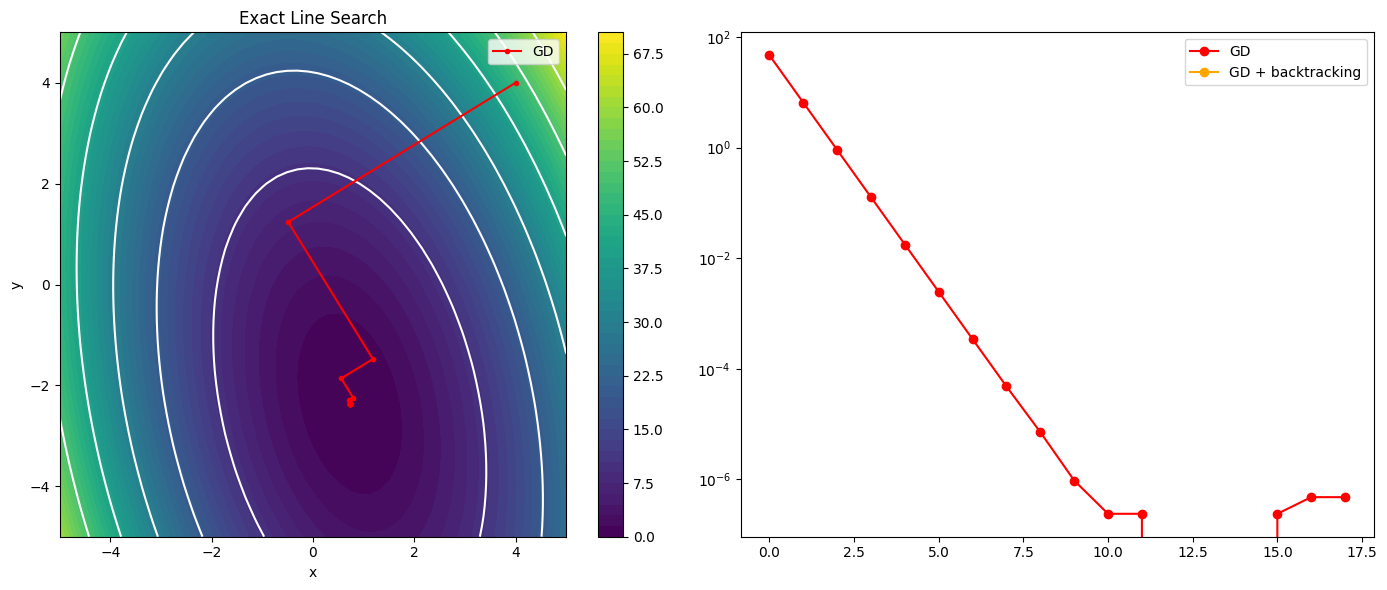

In [92]:
x, path = exact_line_search_quadratic(quadratic_A, quadratic_b, x0)
plot_optimization_2d(quadratic, path, [], title="Exact Line Search")

### Linear Regression using Stochastic Gradient Descent (SDG)

In this part of the laboratory session, we will implement a simple linear regression model using stochastic gradient descent (SGD) to minimize the mean squared error (MSE). The dataset is synthetic, and we will use JAX for efficient computation and automatic differentiation.

#### Problem Setup

Given a set of data points $ (x_i, y_i) $, the goal is to learn the parameters $ \theta_0 $ and $ \theta_1 $ such that the model predicts $ y = \theta_0 + \theta_1 x $. We will optimize these parameters using SGD to minimize the MSE loss.


### Generate Synthetic Data

We will generate synthetic data where $ y = 1.5 x + 3 $, with some added Gaussian noise. This data will be used to test our linear regression model.

Let us now generate the synthetic dataset using JAX's random number generation functions.


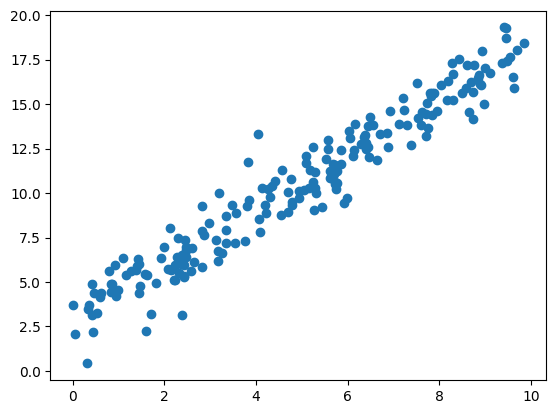

In [93]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
N = 200
x_data = jax.random.uniform(key, shape=(N, ), minval=0, maxval=10)
y_data = 1.5 * x_data + 3 + jax.random.normal(subkey, shape=(N, ))
plt.scatter(x_data, y_data)

In [103]:
# Split into training and validation sets
train_size = int(0.8 * N)
val_size = N - train_size

# Shuffling the indices for a randomized split
key, subkey = jax.random.split(key)
indices = jax.random.permutation(subkey, N)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Creating training and validation sets
x_train, y_train = x_data[train_indices], y_data[train_indices]
x_val, y_val = x_data[val_indices], y_data[val_indices]


### Linear Regression Model

The linear regression model is defined as:

$$ y = \theta_0 + \theta_1 x $$

Where $ \theta_0 $ is the intercept and $ \theta_1 $ is the slope. We will define this model and a loss function to optimize it.


In [104]:
@jax.jit
def model(theta, x):
  return theta[0] + theta[1] * x

### Mean Squared Error (MSE) Loss Function

The loss function we will use is the Mean Squared Error (MSE) between the predicted values and the true values:

$$ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$

We will also use JAX's `jit` decorator to optimize this function for faster computation.


In [105]:
@jax.jit
def mse_loss(theta, x, y):
  y_pred = model(theta, x)
  return jnp.mean((y_pred - y)**2)

### Gradient of the Loss Function

We can compute the gradient of the MSE loss function with respect to the parameters $ \theta_0 $ and $ \theta_1 $ using JAX's automatic differentiation. This will allow us to update the parameters using gradient descent.


In [106]:
grad_mse_loss = jax.jit(jax.grad(mse_loss))

### Stochastic Gradient Descent (SGD) Update Step

In Stochastic Gradient Descent (SGD), we update the parameters using the gradient computed on a random mini-batch of the data. This allows for faster convergence compared to using the full dataset at each iteration.

We will define a function to perform a single update step of SGD.

In [107]:
@jax.jit
def sgd_update(theta, x_batch, y_batch, lr):
  grads = grad_mse_loss(theta, x_batch, y_batch)
  return theta - lr * grads


### Stochastic Gradient Descent with Mini-batches

We will implement the full Stochastic Gradient Descent (SGD) algorithm, processing the data in mini-batches. At each epoch, we shuffle the data and update the parameters using the mini-batch gradients.

Let's now define the `stochastic_gradient_descent` function.


In [108]:
def stochastic_gradient_descent(
    theta,
    training_input,
    training_labels,
    validation_input,
    validation_labels,
    learning_rate=0.01,
    epochs=100,
    batch_size=10,
    state=0,
):
    key = jax.random.PRNGKey(state)
    # Iterate over the number of epochs
    for epoch in range(epochs):
        # Shuffle data indices using JAX's random key
        key, subkey = jax.random.split(key)
        perm = jax.random.permutation(subkey, len(training_input))
        # Process data in mini-batches
        for i in range(0, len(training_input), batch_size):
            batch_idx = perm[i : i + batch_size]
            x_batch = training_input[batch_idx]
            y_batch = training_labels[batch_idx]
            # Perform SGD update
            theta = sgd_update(theta, x_batch, y_batch, learning_rate)
        # Print the loss every 10 epochs
        if epoch % 10 == 0:
            loss = mse_loss(theta, validation_input, validation_labels)
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
    return theta

### Optimized Parameters

After running the optimization, we will obtain the optimized values of $ \theta_0 $ and $ \theta_1 $. These parameters define the best-fit line for the data.

Let's print the optimized parameters.


In [109]:
# Run the Stochastic Gradient Descent
theta = jnp.array(
    [0.0, 0.0]
)  # Initial guess for theta_0 (intercept) and theta_1 (slope)
theta_opt = stochastic_gradient_descent(
    theta, x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=100, batch_size=10
)
print(
    f"Optimized parameters: theta_0 = {theta_opt[0]:.2f}, theta_1 = {theta_opt[1]:.2f}"
)

Epoch 0, Loss: 3.0671
Epoch 10, Loss: 1.8781
Epoch 20, Loss: 1.5836
Epoch 30, Loss: 1.4803
Epoch 40, Loss: 1.6821
Epoch 50, Loss: 1.4405
Epoch 60, Loss: 1.4910
Epoch 70, Loss: 1.4602
Epoch 80, Loss: 1.3967
Epoch 90, Loss: 1.4508
Optimized parameters: theta_0 = 2.72, theta_1 = 1.55


### Visualizing the Results

Finally, we can plot the original data points and the regression line defined by the optimized parameters.


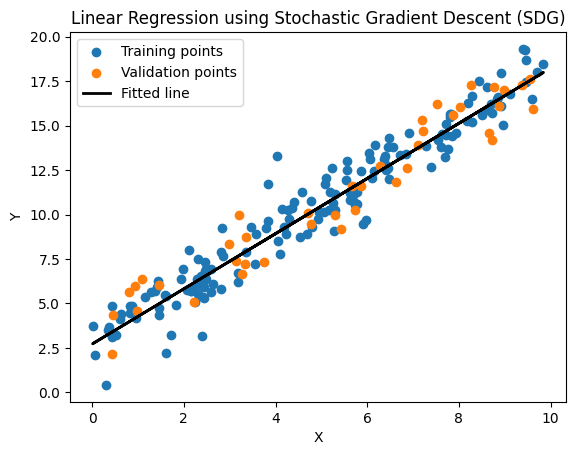

In [110]:
# After the training loop, use the optimized parameters to plot the regression line
# Generate predictions using the optimized parameters
y_pred = model(theta_opt, x_data)

# Plot the original data points
plt.scatter(x_train, y_train, label="Training points")
plt.scatter(x_val, y_val, label="Validation points")

# Plot the regression line
plt.plot(x_data, y_pred, label="Fitted line", color="black", linewidth=2)

# Add labels and a legend
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Linear Regression using Stochastic Gradient Descent (SDG)")
plt.legend()
plt.show()